In [3]:
import numpy as np

def aging_process(A, gamma0, gamma1, ratio, step_size):
    N = A.shape[0]
    # V: vitality vector 0 is dead, 1 is alive
    # T: the supporters required for each node
    V = np.ones(N)
    T = np.sum(A, axis=1) * ratio  # sum of each row
    V_status = np.zeros((N, step_size))

    for i in range(step_size):
        # mechanism B
        # Rule (b)
        rand_vector = np.random.rand(N)
        ind_kill = (V == 1) & (rand_vector < gamma0)
        rand_vector = np.random.rand(N)
        ind_rescue = (V == 0) & (rand_vector < gamma1)
        V[ind_kill] = 0
        V[ind_rescue] = 1

        # Rule (c)
        D = np.dot(A, V) > T
        V_old = V.copy()
        V = V_old * D
        while np.sum(np.abs(V_old - V)) != 0:
            D = np.dot(A, V) > T
            V_old = V.copy()
            V = V_old * D

        # V_status: the vitality state vector of time t
        V_status[:, i] = V

    return V_status


In [4]:
import igraph
import matplotlib.pyplot as plt
gamma0 = 0.0025
ggratio = 120
gamma1 = ggratio * gamma0

ratio = 0.4999

graph_size = 1000
step_size = 1000

In [5]:
def MonteCarlo(m):
    # 生成图
    g1 = igraph.Graph.Barabasi(graph_size, m=1, directed=True)
    g2 = igraph.Graph.Barabasi(graph_size, m=1, directed=True)
    A1 = np.array(g1.get_adjacency().data)
    A2 = np.array(g2.get_adjacency().data)
    A = A1 + A2.T

    # 获取 aging_process 的结果
    object = aging_process(A, gamma0, gamma1, ratio, step_size)
    phi = np.sum(object, axis=0)  # 沿着列方向求和，得到长度为 step_size 的向量
    plt.plot(object.sum(axis=0))
    plt.xlabel('Time')
    plt.ylabel('Vitality')
    plt.show()
    phi_bar = phi_bar = np.cumsum(phi) / np.arange(1, step_size + 1)
    z = abs(phi - phi_bar)
    return z

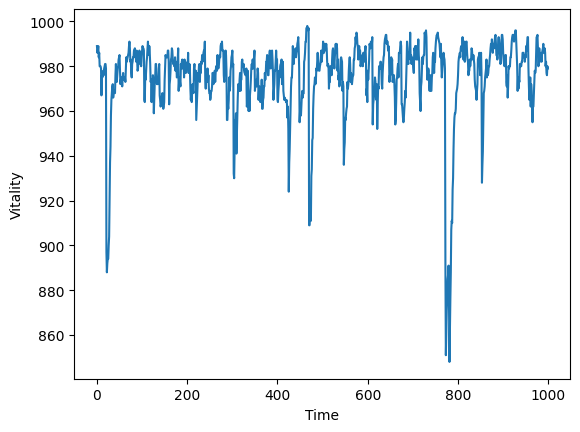

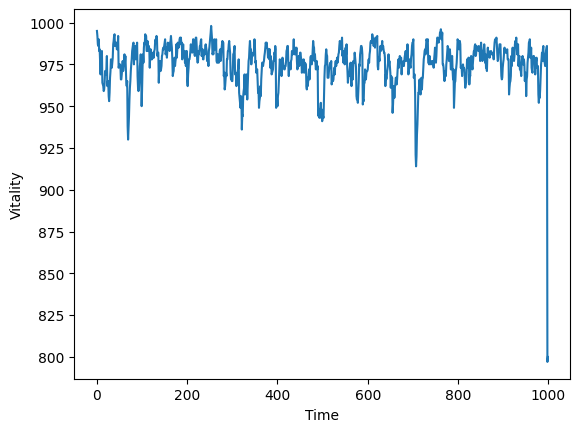

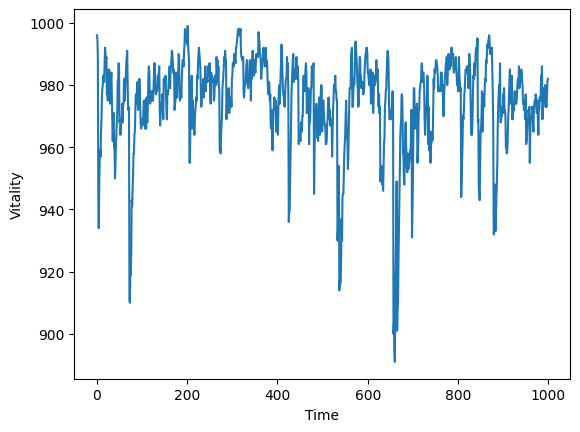

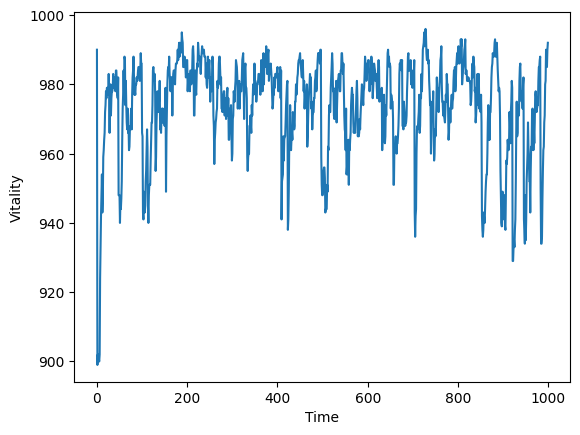

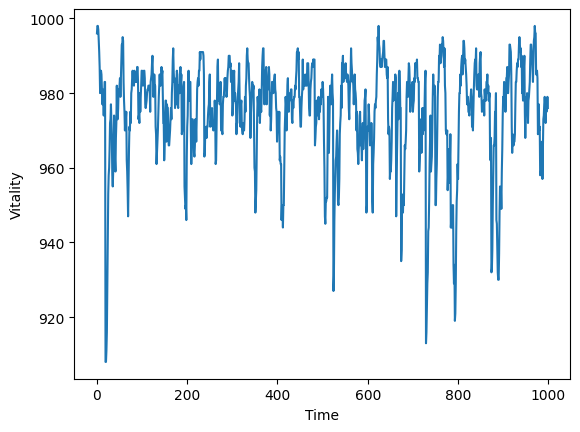

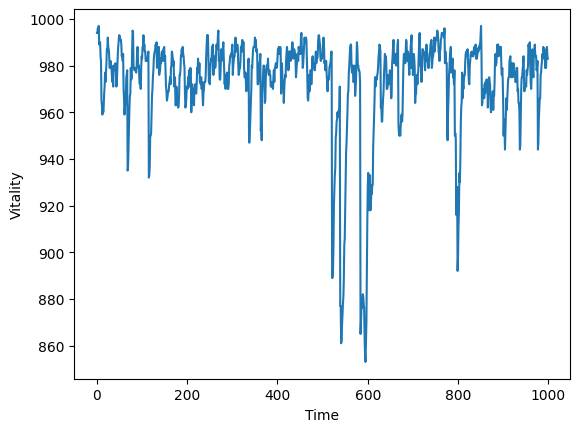

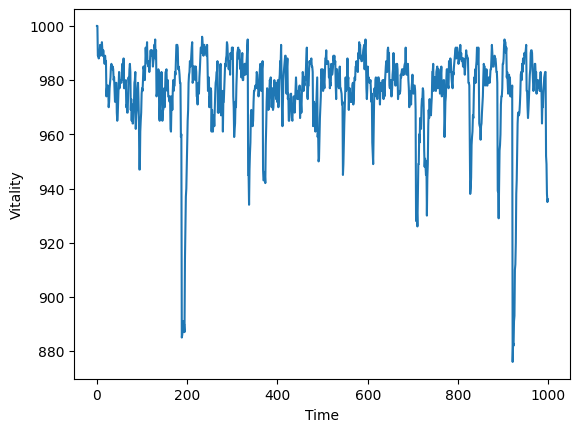

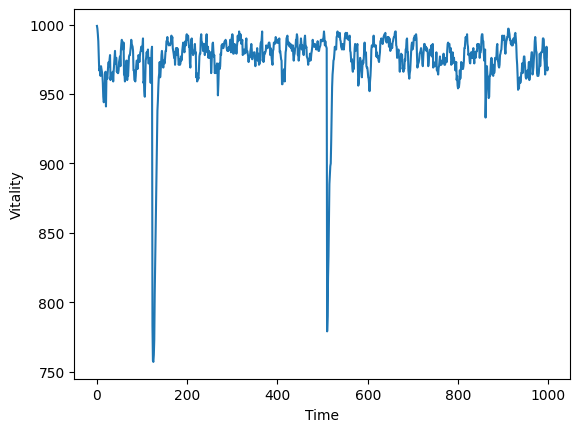

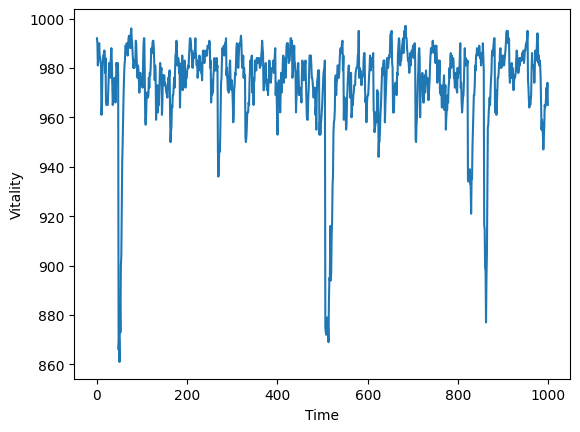

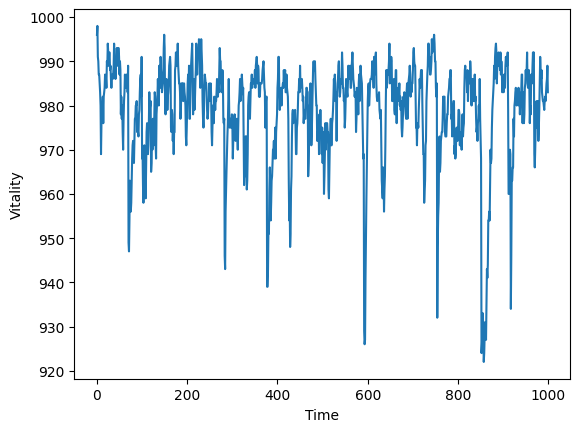

simtable_matrix 的形状为: (10, 1000)


In [6]:
simtable = []

simtable = [MonteCarlo(i) for i in range(10)]
simtable_matrix = np.vstack(simtable)
print("simtable_matrix 的形状为:", simtable_matrix.shape)


mean_zm is 9.150469715750324
var_zm is 14.664960866937637
mean_zm is 8.968148158956371
var_zm is 14.588716593577589
mean_zm is 8.74500460764216
var_zm is 13.889860053500058
mean_zm is 8.562683050848205
var_zm is 14.199020566825237
mean_zm is 8.457322535190379
var_zm is 13.988353965496295
mean_zm is 8.275000978396424
var_zm is 13.68293833949872
mean_zm is 8.23417898387617
var_zm is 13.50732423483564
mean_zm is 8.051857427082215
var_zm is 13.356108186917526
mean_zm is 7.86953587028826
var_zm is 13.093344190685404
mean_zm is 7.764175354630434
var_zm is 12.935006247346022
mean_zm is 7.64639231897405
var_zm is 12.728506423762502
mean_zm is 7.5410318033162245
var_zm is 12.539770915331484
mean_zm is 7.35871024652227
var_zm is 12.380251575790322
mean_zm is 7.176388689728315
var_zm is 12.060639799116602
mean_zm is 7.13556669520806
var_zm is 12.00141487345313
mean_zm is 6.953245138414105
var_zm is 11.73828129059499
mean_zm is 6.847884622756279
var_zm is 11.529994728880714
slope: 1.37493238662496

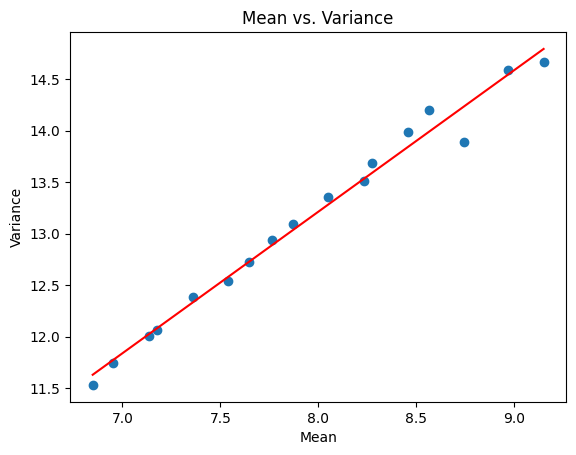

In [7]:
# 将simtable展开并转换为矩阵
z = np.array(simtable).flatten()
matz = np.reshape(z, (1000, 10), order='F')

# 移除前50个观测
cut_matz = matz[100:, :]

# 计算长度模除(3到100)的余数
tmp = len(cut_matz.flatten()) % np.arange(10, 101)

# 计算每个bin的数量
bin_num = np.arange(10, 101)[tmp == 0]

# 计算均值和方差
mean_zm = np.empty(len(bin_num))
var_zm = np.empty(len(bin_num))

for j, num in enumerate(bin_num):
    id_ = np.repeat(np.arange(1, num + 1), np.ceil(len(cut_matz.flatten()) / num).astype(int))[:len(cut_matz.flatten())]
    zm = np.empty(num)
    for i in range(1, num + 1):
        zm[i - 1] = np.sum(cut_matz.flatten()[id_ == i])
    mean_zm[j] = np.log(np.mean(zm))
    var_zm[j] = np.log(np.var(zm))
    print(f"mean_zm is {mean_zm[j]}")
    print(f"var_zm is {var_zm[j]}")

x = mean_zm
y = var_zm

# 绘制均值方差图
m1 = np.polyfit(x, y, 1)
print("slope:", m1[0])
print("intercept:", m1[1])
plt.scatter(x, y)
plt.plot(x, m1[0] * x + m1[1], color='red')
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Mean vs. Variance")
plt.show()

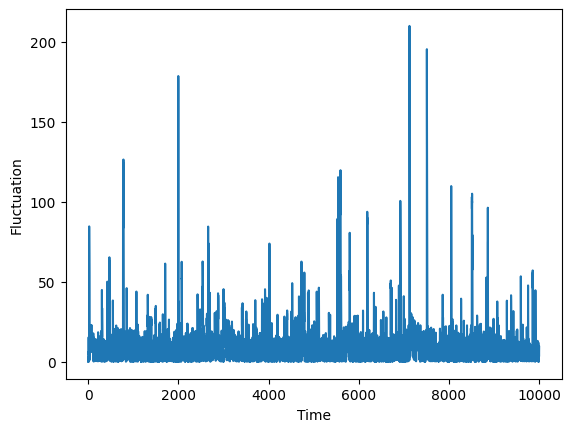

In [8]:
import matplotlib.pyplot as plt

plt.plot(z)
plt.xlabel('Time')
plt.ylabel('Fluctuation')
plt.show()

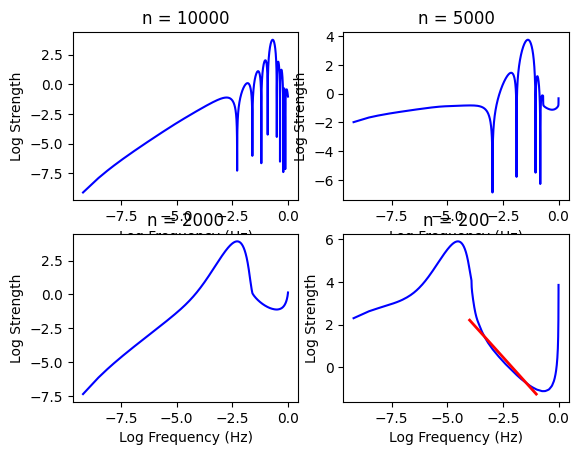

In [12]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Fourier transformation
X_k = np.fft.fft(z)

# Define filtering parameters
n_values = [10000, 5000, 2000, 200]
b_values = [signal.firwin(n, cutoff=0.001, window='hamming') for n in n_values]

# Apply hamming window filter and compute log values
filtered_data = []
for b in b_values:
    filtered_z = np.abs(signal.lfilter(b, 1, np.abs(X_k)))
    filtered_data.append(np.log(filtered_z))

# Compute log values for x axis
a = np.log(np.arange(1, len(X_k) + 1) / len(filtered_data[0]))

# Plot filtered data
fig, axs = plt.subplots(2, 2)
for i, (n, z) in enumerate(zip(n_values, filtered_data)):
    row = i // 2
    col = i % 2
    axs[row, col].plot(a, z, color="blue", markersize=0.7)
    axs[row, col].set_xlabel("Log Frequency (Hz)")
    axs[row, col].set_ylabel("Log Strength")
    axs[row, col].set_title("n = {}".format(n))

# Fit straight line
ind = (a < -1) & (a > -4)
m1 = np.polyfit(a[ind], filtered_data[-1][ind], 1)
plt.plot(a[ind], np.polyval(m1, a[ind]), color='red', linewidth=2)

plt.show()
